In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

students = pd.read_csv('student.csv')

print(students.head())
print(students.describe(include='all'))

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]
       school  sex         age address famsize Pstatus        Medu  \
count     649  649

In [30]:
# Load and basic checks
#1) Load data and minimal checks
#Assumes student.csv is in the working directory. If we already have a dataframe in memory named students, skip the read and set df = students.copy().
import pandas as pd

try:
    df = students.copy()
except NameError:
    df = pd.read_csv('student.csv')

print(df.head())
print(df.shape)

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]
(649, 33)


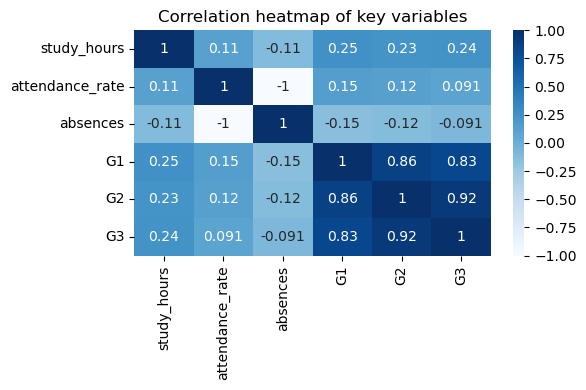

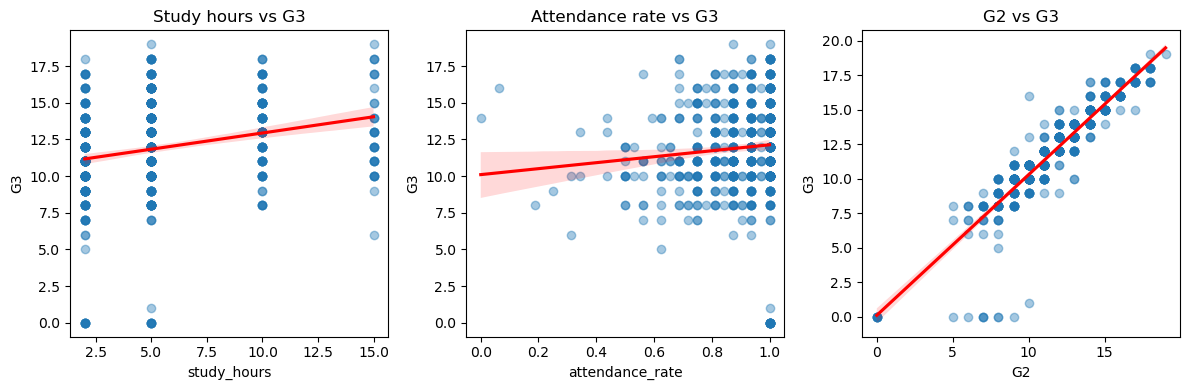

   study_hours  attendance_rate  absences  G1  G2  G3
0            5           0.8750         4   0  11  11
1            5           0.9375         2   9  11  11
2            5           0.8125         6  12  13  12
3           10           1.0000         0  14  14  14
4            5           1.0000         0  11  13  13


In [32]:
# Feature engineering + EDA visuals
#2) Feature engineering and EDA visuals
import seaborn as sns
import matplotlib.pyplot as plt

df = df.copy()
study_map = {1:2, 2:5, 3:10, 4:15}
if 'studytime' in df.columns:
    df['study_hours'] = df['studytime'].map(study_map)

if 'absences' in df.columns:
    max_abs = max(1, df['absences'].max())
    df['attendance_rate'] = 1 - (df['absences'] / max_abs)

num_cols = [c for c in ['study_hours','attendance_rate','absences','G1','G2','G3'] if c in df.columns]
num_df = df[num_cols].dropna()

plt.figure(figsize=(6,4))
sns.heatmap(num_df.corr(numeric_only=True), annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation heatmap of key variables')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
if 'study_hours' in num_df.columns:
    plt.subplot(1,3,1)
    sns.regplot(x='study_hours', y='G3', data=num_df, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
    plt.title('Study hours vs G3')

plt.subplot(1,3,2)
sns.regplot(x='attendance_rate', y='G3', data=num_df, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title('Attendance rate vs G3')

plt.subplot(1,3,3)
sns.regplot(x='G2', y='G3', data=num_df, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title('G2 vs G3')

plt.tight_layout()
plt.show()

print(num_df.head())

In [34]:
# Baseline linear regression
#3) Baseline linear model (G3 ~ G2 + study_hours + attendance_rate)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

features = [c for c in ['G2','study_hours','attendance_rate'] if c in df.columns]
X1 = df[features].copy()
y = df['G3'].copy()

mask = X1.notnull().all(axis=1) & y.notnull()
X1 = X1[mask]
y1 = y[mask]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
lin = LinearRegression()
lin.fit(X1_train, y1_train)
pred1 = lin.predict(X1_test)

print(r2_score(y1_test, pred1))
print(mean_absolute_error(y1_test, pred1))
print(lin.coef_)
print(lin.intercept_)

0.8680979205495233
0.74011025904959
[ 1.02703082  0.03146903 -0.63169128]
0.4213568462887842


In [36]:
#4) Regularized model with selected categoricals (Ridge)
# Ridge with selected categoricals
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV

cat_cols = [c for c in ['sex','address','famsize','Pstatus','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'] if c in df.columns]
num_cols = [c for c in ['age','Medu','Fedu','traveltime','studytime','failures','absences','G1','G2'] if c in df.columns]

X2 = df[cat_cols + num_cols].copy()
y2 = df['G3'].copy()

mask2 = X2.notnull().all(axis=1) & y2.notnull()
X2 = X2[mask2]
y2 = y2[mask2]

pre = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

ridge = RidgeCV(alphas=np.logspace(-3, 3, 21), cv=5)
pipe = Pipeline(steps=[('pre', pre), ('model', ridge)])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
pipe.fit(X2_train, y2_train)
pred2 = pipe.predict(X2_test)

print(r2_score(y2_test, pred2))
print(mean_absolute_error(y2_test, pred2))
print(pipe.named_steps['model'].alpha_)

0.861248041449079
0.7286338400893947
125.89254117941663


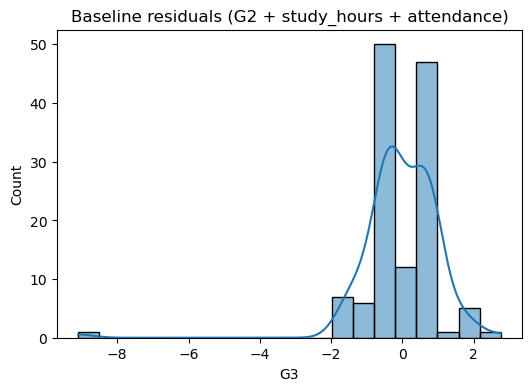

     G2  study_hours  attendance_rate  actual_G3    pred_G3
636  18            5          0.87500         19  18.512527
220  11            5          0.93750         12  11.283830
594  18            5          1.00000         18  18.433566
429  11            5          0.84375         11  11.343052
72   11            5          0.93750         11  11.283830


In [38]:
#5) Optional: Residual checks and save predictions
# Residuals and optional save
import matplotlib.pyplot as plt

res1 = y1_test - pred1
plt.figure(figsize=(6,4))
sns.histplot(res1, bins=20, kde=True)
plt.title('Baseline residuals (G2 + study_hours + attendance)')
plt.show()

pred_df = X1_test.copy()
pred_df['actual_G3'] = y1_test.values
pred_df['pred_G3'] = pred1
print(pred_df.head())

# Uncomment to save
# pred_df.to_csv('student_baseline_predictions.csv', index=False)